# Testing DrugAgent and DrugEnv APIs

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [5]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

Instantiate Environment and Agent.

In [6]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'temperature': 1.0, 'strategy': 'replace', 'size': 8}}
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'temperature': 1.0, 'strategy': 'grow', 'size': 8}}
test_surrogate = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
make = {'name': 'make', 'batch_size': 40}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8}
design_and_score = [design_replace, test_surrogate]
sequence = [*(design_and_score * 4), design_grow, test_surrogate, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.0),
    utility_function = utility_agent
)

In [7]:
import json
from tqdm.notebook import tqdm

drug_agent.reset()
observations, _ = drug_env.reset()

for _ in tqdm(range(400)):
    action = drug_agent.act(observations)
    observations, reward, truncated, terminated, _ = drug_env.step(action)
    if action['name'] == 'design':
        print(reward)

  0%|          | 0/400 [00:00<?, ?it/s]

{'reaction': '13_Carboxylate_and_Amine', 'product': 'CC(C)(C)NC(=O)Cn1ccc(C(F)(F)F)n1', 'reactants': [{'product': 'CC(C)(C)N', 'search': 'similar', 'temperature': 1.0}, {'product': 'O=C(O)Cn1ccc(C(F)(F)F)n1'}]}
{'reaction': '13_Carboxylate_and_Amine', 'product': 'CC(C)(C)NC(=O)Cn1ccc(C(F)(F)F)n1', 'reactants': [{'product': 'CC(C)(C)N'}, {'product': 'O=C(O)Cn1ccc(C(F)(F)F)n1', 'search': 'similar', 'temperature': 1.0}]}
{'reaction': '84_sulfon_amide', 'product': 'CNC1(C(N)=O)CCCC1', 'reactants': [{'product': 'Cl.NC(=O)C1(N)CCCC1', 'search': 'similar', 'temperature': 1.0}, {'product': 'COS(C)(=O)=O'}]}
{'reaction': '84_sulfon_amide', 'product': 'CNC1(C(N)=O)CCCC1', 'reactants': [{'product': 'Cl.NC(=O)C1(N)CCCC1'}, {'product': 'COS(C)(=O)=O', 'search': 'similar', 'temperature': 1.0}]}
{'reaction': '19_Halide_and_Alcohol', 'product': 'CC(Oc1ccccc1F)C(=O)O', 'reactants': [{'product': 'Oc1ccccc1F', 'search': 'similar', 'temperature': 1.0}, {'product': 'CC(Br)C(=O)OC(C)(C)C'}]}
{'reaction': '1

AttributeError: 'NoneType' object has no attribute 'GetPropsAsDict'

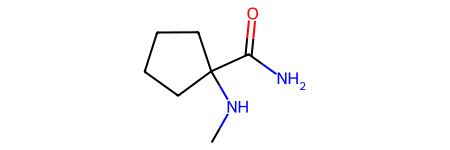

In [12]:
from rdkit.Chem import MolFromSmiles

MolFromSmiles('CNC1(C(N)=O)CCCC1')

In [36]:
from dgym.molecule import Molecule

Molecule.load({
    'reaction': '13_Carboxylate_and_Amine',
    # 'product': 'CNC1(C(N)=O)CCCC1',
    'reactants': [{'search': 'fixed', 'product': 'CNC1(C(N)=O)CCCC1'}, {'search': 'random', 'size_limit': 10, 'seed': 6871370448492419224}]
})

AttributeError: 'NoneType' object has no attribute 'GetPropsAsDict'

In [29]:
designer.design(observations[7], strategy='grow')

AttributeError: 'NoneType' object has no attribute 'GetPropsAsDict'

In [154]:
import numpy as np
sort = np.argsort(drug_env.utility_function(observations.tested, use_precomputed=True, method='average'))

In [171]:
print(json.dumps(sequence, indent=4))

[
    {
        "name": "design",
        "batch_size": 5,
        "parameters": {
            "temperature": 1.0,
            "size": 8
        }
    },
    {
        "name": "Noisy ABL1 pIC50",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "Noisy Log S",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "Noisy Log P",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "make",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "ABL1 pIC50",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "Log S",
        "batch_size": 40,
        "parameters": {}
    },
    {
        "name": "Log P",
        "batch_size": 40,
        "parameters": {}
    }
]
